Numba is a just-in-time compiler (JIT) for Python code focused on NumPy arrays and scientific Python. I've seen various tutorials around the web and in conferences, but I have yet to see someone use Numba "in the wild". In the past few months, I've been using Numba in my own code, and I recently released my first real package using Numba, [skan](). The short version is that Numba is *amazing* and you should strongly consider it to speed up your scientific Python bottlenecks. Read on for the longer version.

## Part 1: some toy examples

Let me illustrate what Numba is good for with the most basic example: adding two arrays together. You've probably seen similar examples around the web.

We start by defining a pure Python function for iterating over a pair of arrays and adding them:

In [1]:
import numpy as np


def addarr(x, y):
    result = np.zeros_like(x)
    for i in range(x.size):
        result[i] = x[i] + y[i]
    return result

How long does this take in pure Python?

In [2]:
n = int(1e6)
a = np.random.rand(n)
b = np.random.rand(n)

In [3]:
%timeit -r 1 -n 1 addarr(a, b)

1 loop, best of 1: 545 ms per loop


About half a second on my machine. Let's try with Numba using its JIT decorator:

In [4]:
import numba

addarr_nb = numba.jit(addarr)

In [5]:
%timeit -r 1 -n 1 addarr_nb(a, b)

1 loop, best of 1: 210 ms per loop


The first time it runs, it's only a tiny bit faster. That's because of the nature of JITs: they only compile code *as it is being run*, in order to use object type information of the objects passed into the function. (Note that, in Python, the arguments `a` and `b` to `addarr` could be anything: an array, as expected, but also a list, a tuple, even a `Banana`, if you've defined such a class, and the meaning of the function body is different for each of those types.)

Let's see what happens the next time we run it:

In [6]:
%timeit -r 1 -n 1 addarr_nb(a, b)

1 loop, best of 1: 5.63 ms per loop


Whoa! Now the code takes 5ms, about 100 times faster than the pure Python version. And the NumPy equivalent?

In [7]:
%timeit -r 1 -n 1 a + b

1 loop, best of 1: 5.96 ms per loop


Only marginally faster than Numba, even though NumPy addition is implemented in highly optimised C code. And, for some data types, Numba even beats NumPy:

In [8]:
r = np.random.randint(0, 128, size=n).astype(np.uint8)
s = np.random.randint(0, 128, size=n).astype(np.uint8)

In [9]:
%timeit -r 1 -n 1 r + s

1 loop, best of 1: 6.18 ms per loop


In [10]:
%timeit -r 1 -n 1 addarr_nb(r, s)

1 loop, best of 1: 192 ms per loop


In [11]:
%timeit -r 1 -n 1 addarr_nb(r, s)

1 loop, best of 1: 253 µs per loop


WOW! For smaller data types, Numba beats NumPy by over 10x!

I'm only speculating, but since my clock speed is about 1GHz (I'm writing this on a base Macbook with a 1.1GHz Core-m processor), I suspect that Numba is taking advantage of some [SIMD]() capabilities of the processor, whereas NumPy is treating each array element as an individual arithmetic operation. (If any Numba or NumPy devs are reading this and have more concrete implementation details that explain this, please share them in the comments!)

So hopefully I've got your attention now. For years, NumPy has been the go-to library for performance Python in scientific computing. But, if you wanted to do something a little out of the ordinary, you were stuck. Now, Numba generally matches that for arbitrary code and sometimes beats it handily!

In this context, I decided to use Numba to do something a little less trivial, as part of my research.

## Part 2: Real Numba

I'll present below a slightly simplified version of the code present in my library, [skan](), which is currently available on PyPI and conda-forge. The task is to build an graph out of the pixels of a skleton image, like this one:

In [12]:
%matplotlib inline

In [16]:
import matplotlib.pyplot as plt
plt.style.use('/Users/jni/projects/elegant-scipy/style/elegant.mplstyle')

In [43]:
skeleton = np.array([[0, 1, 0, 0, 0, 1, 1],
                     [0, 0, 1, 1, 1, 0, 0],
                     [0, 1, 0, 0, 0, 1, 0],
                     [0, 0, 1, 0, 1, 0, 0],
                     [1, 1, 0, 1, 0, 0, 0]], dtype=bool)
skeleton = np.pad(skeleton, pad_width=1, mode='constant')

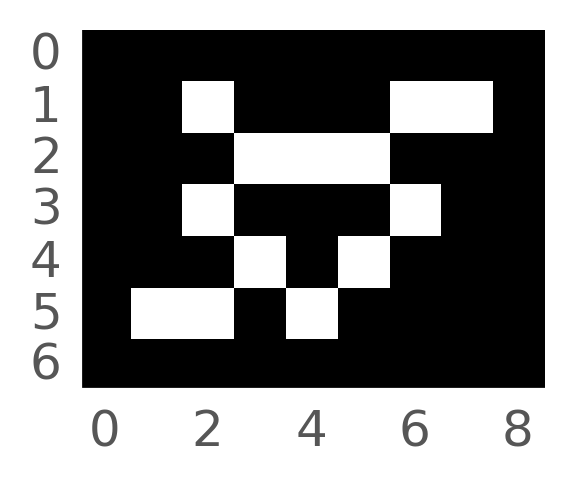

In [44]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(skeleton)

Every white pixel in the image will be a node in our graph, and we place edges between nodes if the pixels are next to each other (counting diagonals). A natural way to represent a graph in the SciPy world is as a sparse matrix $A$: we number the nonzero pixels from 1 onwards — these are the rows of the matrix — and then place a 1 at entry $A_{i, j}$ when pixel $i$ is adjacent to pixel $j$. SciPy's `sparse.coo_matrix` format make it very easy to construct such a matrix: we just need an array with the row coordinates and another with the column coordinates.

Because NumPy arrays are not dynamically resizable like Python lists, it helps to know ahead of time how many edges we are going to need to put in our row and column arrays. Thankfully, a well-known theorem of graph theory states that the number of edges of a graph is half the sum of the degrees. In our case, because we want to add the edges twice (once from $i$ to $j$ and once from $j$ to $i$, we just need the sum of the degrees exactly. We can find this out with a convolution using `scipy.ndimage`:

In [49]:
from scipy import ndimage as ndi

neighbors = np.array([[1, 1, 1],
                      [1, 0, 1],
                      [1, 1, 1]])

degrees = ndi.convolve(skeleton.astype(int), neighbors) * skeleton

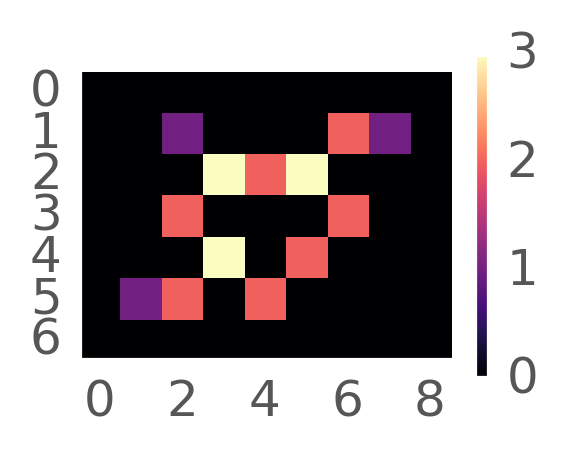

In [70]:
fig, ax = plt.subplots(figsize=(2, 2))
result = ax.imshow(degrees, cmap='magma')
cbar = fig.colorbar(result, ax=ax, shrink=0.7)
cbar.set_ticks([0, 1, 2, 3])

There you can see "tips" of the skeleton, with only 1 neighbouring pixel, as purple, "paths", with 2 neighbours, as red, and "junctions", with 3 neighbors, as yellow.

Now, consider the pixel at position $(1, 6)$. It has two neighbours (as indicated by its colour): $(2, 5)$ and $(1, 7)$. If we number the nonzero pixels as $1, 2, ..., n$ from left to right and top to bottom, then this pixel has label 2, and its neighbours have labels 6 and 3. We therefore need to add edges (2, 3) and (2, 6) to the graph. Similarly, when we consider pixel 6, we will add edges (6, 5), (6, 3), and (6, 8).

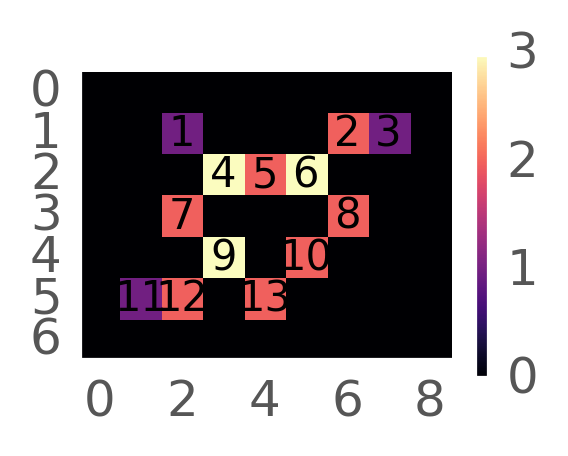

In [103]:
fig, ax = plt.subplots(figsize=(2, 2))
result = ax.imshow(degrees, cmap='magma')
cbar = fig.colorbar(result, ax=ax, shrink=0.7)
cbar.set_ticks([0, 1, 2, 3])

nnz = len(np.flatnonzero(degrees))
pixel_labels = np.arange(nnz) + 1
for lab, y, x in zip(pixel_labels, *np.nonzero(degrees)):
    ax.text(x, y, lab, horizontalalignment='center',
            verticalalignment='center')

Scanning over the whole image, we see that we need `row` and `col` arrays of length exactly `np.sum(degrees)`.

In [136]:
n_edges = np.sum(degrees)
row = np.empty(n_edges, dtype=np.int32)  # type expected by scipy.sparse
col = np.empty(n_edges, dtype=np.int32)

The final piece of the puzzle is finding neighbours. For this, we need to know a little about how NumPy stores arrays. Even though our array is 2-dimensional (rows and columns), these are all arrayed in a giant line, each row placed one after the other. (This is called "C-order".) If we index into this linearised array ("raveled", in NumPy's language), we can make sure that our code works for 2D, 3D, and even higher-dimensional images. Using this indexing, neighbouring pixels to the left and right are accessed by subtracting or adding 1 to the current index. Neighbouring pixels above and below are accessed by subtracting or adding the length of a whole row. Finally, diagonal neighbours are found by combining these two. For simplicity, we only show the 2D version below:

In [161]:
def neighbour_steps(shape):
    step_sizes = np.cumprod((1,) + shape[-1:0:-1])
    axis_steps = np.array([[-1, -1],
                           [-1,  1],
                           [ 1, -1],
                           [ 1,  1]])
    diag = axis_steps @ step_sizes
    steps = np.concatenate((step_sizes, -step_sizes, diag))
    return steps

In [162]:
steps = neighbour_steps(degrees.shape)
print(steps)

[  1   9  -1  -9 -10   8  -8  10]


Of course, if we use these steps near the right edge of the image, we'll wrap around, and mistakenly think that the first element of the next row is a neighbouring pixel! Our solution is to only process nonzero pixels, and make sure that we have a 1-pixel-wide "pad" of zero pixels — which we do, in the image above!

Now, we iterate over image pixels, look at neighbors, and populate the `row` and `column` vectors.

In [147]:
def build_graph(labeled_pixels, steps_to_neighbours, row, col):
    start = np.max(steps_to_neighbours)
    end = len(labeled_pixels) - start
    elem = 0  # row/col index
    for k in range(start, end):
        i = labeled_pixels[k]
        if i != 0:
            for s in steps:
                neighbour = k + s
                j = labeled_pixels[neighbour]
                if j != 0:
                    row[elem] = i
                    col[elem] = j
                    elem += 1

In [163]:
skeleton_int = np.ravel(skeleton.astype(np.int32))
skeleton_int[np.nonzero(skeleton_int)] = 1 + np.arange(nnz)

In [177]:
%timeit -r 1 -n 1 build_graph(skeleton_int, steps, row, col)

1 loop, best of 1: 540 µs per loop


Now we try the Numba version:

In [170]:
build_graph_nb = numba.jit(build_graph)

In [171]:
%timeit -r 1 -n 1 build_graph_nb(skeleton_int, steps, row, col)

1 loop, best of 1: 183 ms per loop


In [172]:
%timeit -r 1 -n 1 build_graph_nb(skeleton_int, steps, row, col)

1 loop, best of 1: 12.6 µs per loop


Nice! We get close to a 50x speedup using Numba, and this operation would have been difficult if not impossible to convert to a NumPy vectorized operation! We can now build our graph:

In [175]:
from scipy import sparse
G = sparse.coo_matrix((np.ones_like(row), (row, col))).tocsr()

As to what to *do* with said graph, I'll leave that for another post. (You can also peruse the [skan source code](https://github.com/jni/skan).) In the meantime, though, you can visualize it with NetworkX:

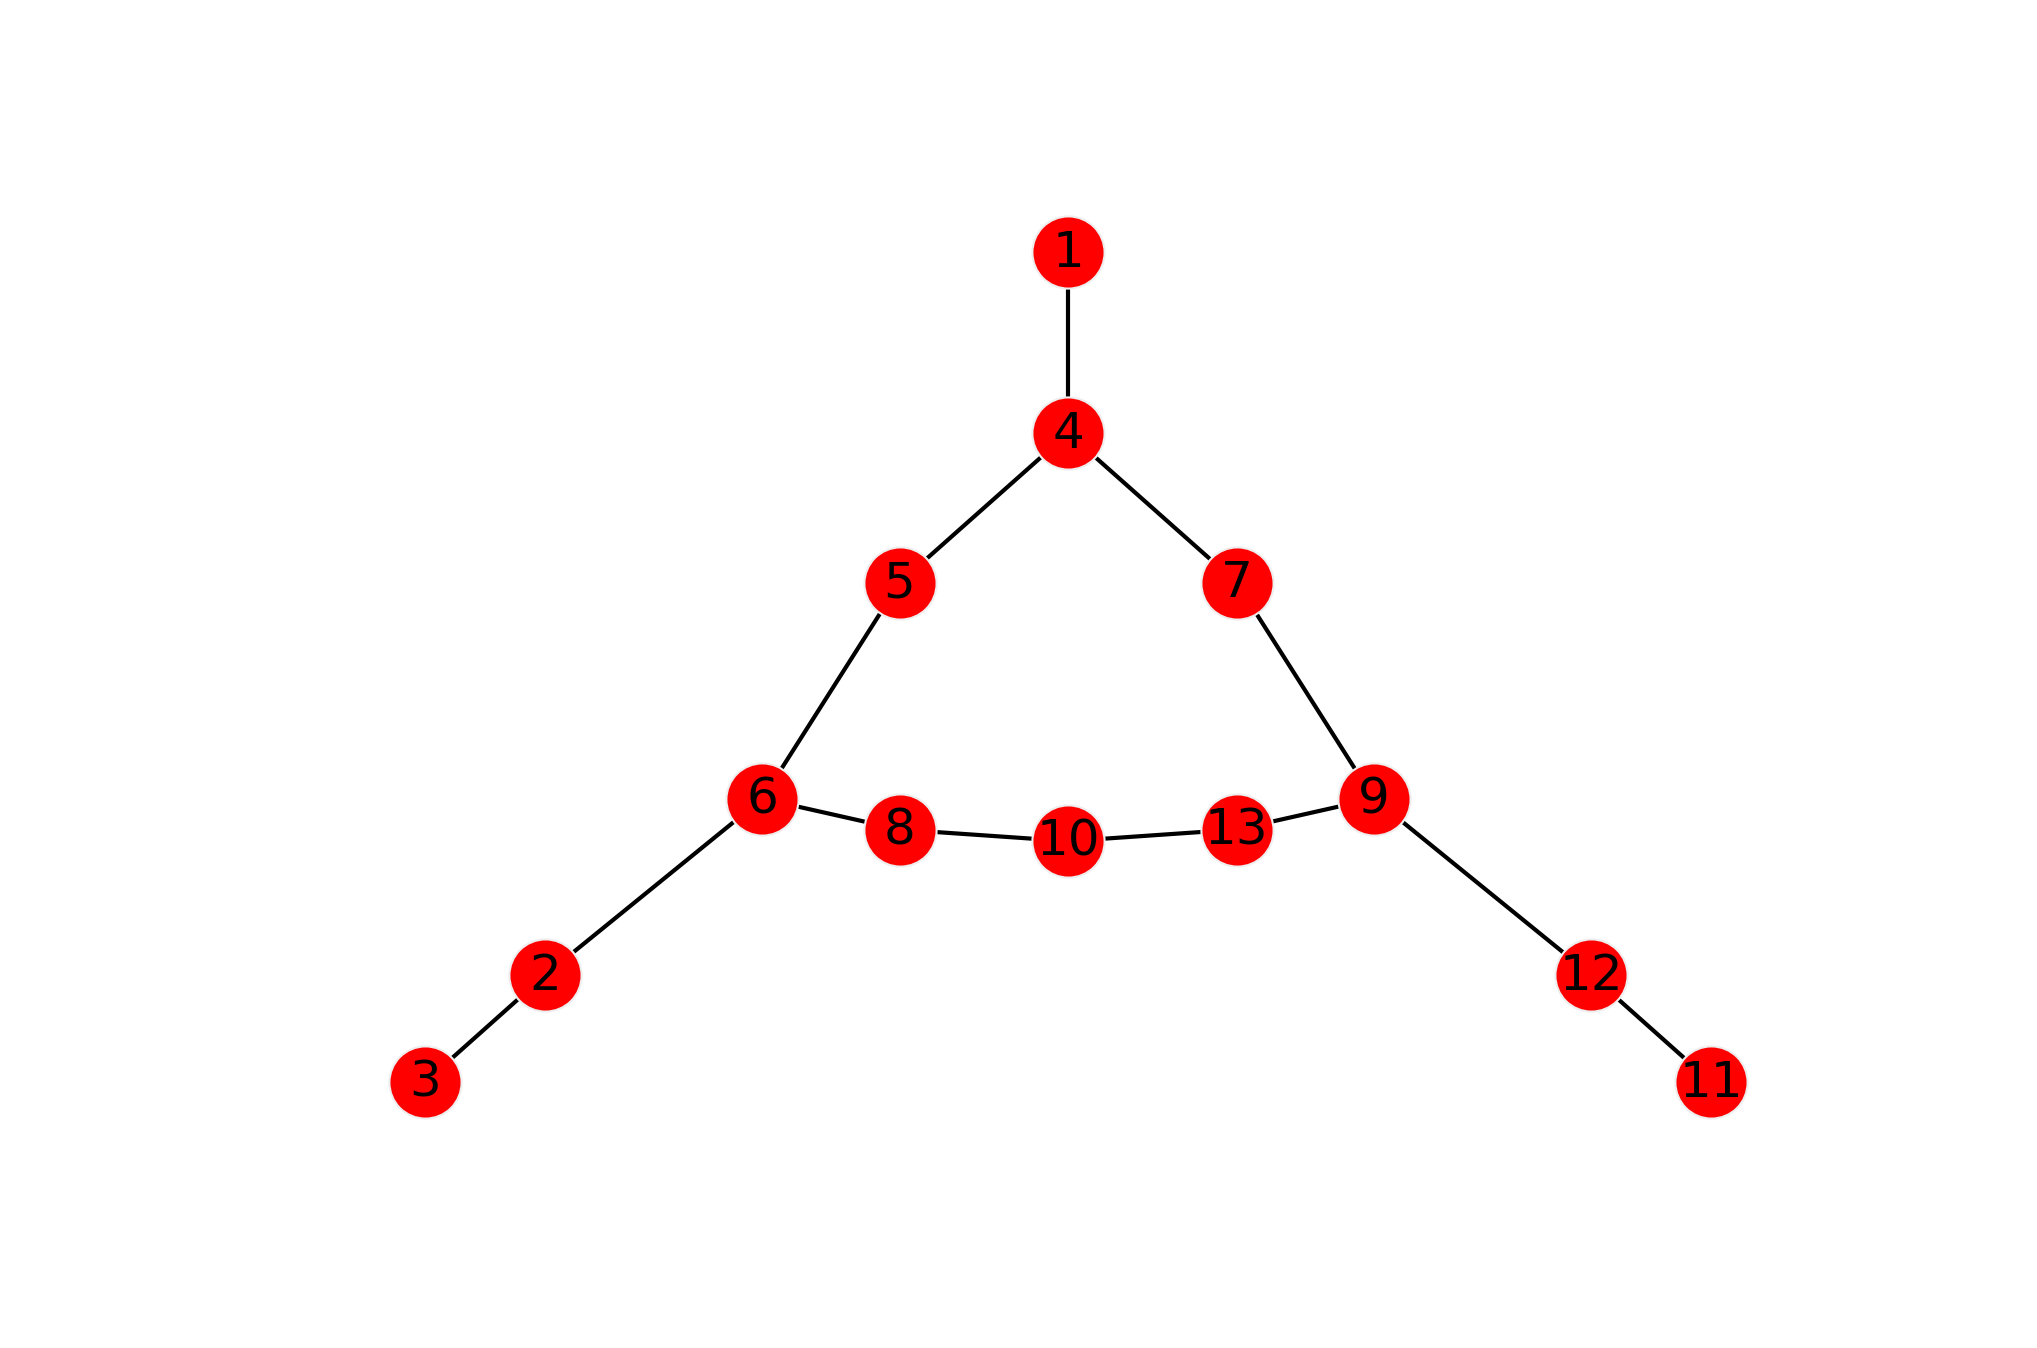

In [191]:
import networkx as nx

Gnx = nx.from_scipy_sparse_matrix(G)
Gnx.remove_node(0)

nx.draw_spectral(Gnx, with_labels=True)

There's our pixel graph! Obviously, the speedup and n-d